In [3]:
import pandas as pd
import numpy as np
from collections import Counter
from nltk import ngrams
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from nltk.draw.dispersion import dispersion_plot
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import multiprocessing
from gensim.models import Word2Vec
from time import time
import matplotlib.cm as cm

In [4]:
# Leer el archivo csv cómo un df
df = pd.read_csv('balanced_sampled_data.csv')

# Pasar todos los caracteres a minusculas y tokenizar por espacios
splitted_reviews = df['reviewText'].str.lower().str.split()

## FRECUENCIA DE PALABRAS

In [6]:
print(f"Vista preliminar del df: \n{df.head()} \n")

print(f"Númweor de reviews: \n {len(df)} \n")

print(f"Df sobre el que se trabajará: \n{splitted_reviews[:10]}")

Vista preliminar del df: 
   overall                                         reviewText
0      1.0  Deepak Chopra would like to introduce you to J...
1      1.0  this games sucks. spend your time on somthing ...
2      1.0  Don't waste your money. Nothing here you can't...
3      1.0  How I wish Amazon would make their own content...
4      1.0  Moderately interesting plot, but extremely poo... 

Númweor de reviews: 
 40000 

Df sobre el que se trabajará: 
0    [deepak, chopra, would, like, to, introduce, y...
1    [this, games, sucks., spend, your, time, on, s...
2    [don't, waste, your, money., nothing, here, yo...
3    [how, i, wish, amazon, would, make, their, own...
4    [moderately, interesting, plot,, but, extremel...
5    [i, thought, that, it, was, good, so, far, and...
6                                  [friggin, commies.]
7    [the, reviews, i, read, seemed, worth, it,, th...
8    [i, would, not, call, this, a, book., it's, mo...
9    [i, redommend, you, not, buy, this, if,

In [7]:
# Se llevan todas las palabras a una serie de palabras individuales, contar la frecuencia y las más comunes
words_review = splitted_reviews.apply(pd.Series).stack().reset_index(drop = True)
vocabulary_ = Counter(words_review)
vocabulary_most_common = vocabulary_.most_common()

In [8]:
print(f"Número de palabras: \n {len(words_review)} \n")
print(f"Dimendión del vocabulario: \n {len(vocabulary_)} \n")

print(f"Algunas palabras del corpus: \n{words_review[:10]} \n")
print(f"Palabras más frecuentesdel vocabulario: \n {vocabulary_most_common[:10]}")



Número de palabras: 
 3094737 

Dimendión del vocabulario: 
 129108 

Algunas palabras del corpus: 
0       deepak
1       chopra
2        would
3         like
4           to
5    introduce
6          you
7           to
8       jesus.
9          not
dtype: object 

Palabras más frecuentesdel vocabulario: 
 [('the', 158817), ('and', 86541), ('to', 84791), ('i', 80941), ('a', 80357), ('of', 68957), ('is', 48627), ('this', 46913), ('it', 44582), ('in', 40089)]


In [9]:
# Se realizan algunas operaciones para ordenar y extraer las palabras y sus frecuencias de la lista
words = [w[0] for w in vocabulary_most_common[:10]]
freqs = [w[1] for w in vocabulary_most_common[:10]]

freqs, words = zip(*sorted(zip(freqs, words)))

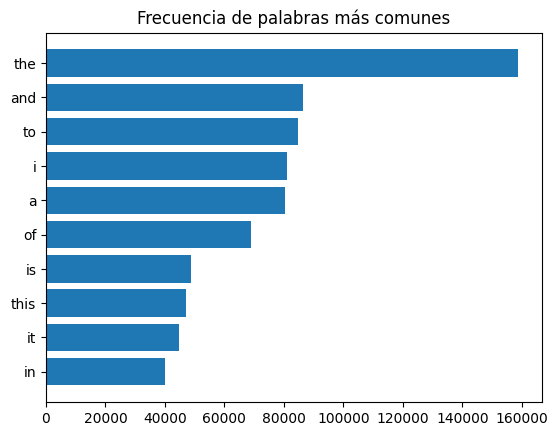

In [10]:
plt.barh(words, freqs)
plt.title('Frecuencia de palabras más comunes')
plt.show()

# Podemos ver como las parlabras más comunes no aportan nada de información sobre el signifiacadoo del texto,
# más adelante serán eliminadas para que los algoritmos puedan aprender sobre el sentido dek texto

## DISTRIBUCIÓN SEGÚN VALORACIONES

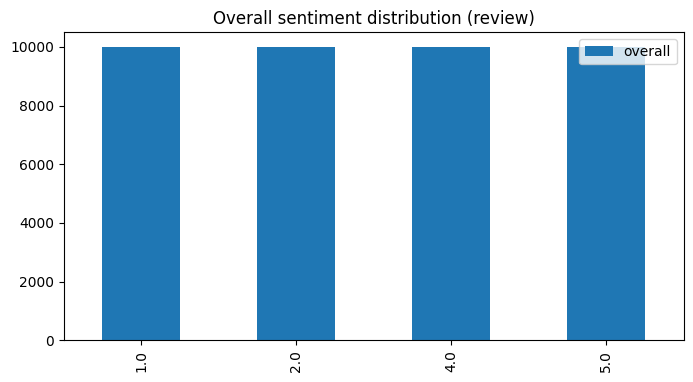

In [12]:
# Disribución de las reviews por sentimiento
aux_df = pd.DataFrame(df['overall'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Overall sentiment distribution (review)', figsize=(8, 4))

# Como es un subset más pequeño del datraset original, hemos podido coger 10.000 palabras de casa sentimiento, por lo que está bien balanceado

In [13]:
def label_sentiment(row):
    """
    Etiqueta de sentimiento basada en la puntuación de sentimiento.

    Esta función toma una fila (normalmente de un DataFrame) que contiene
    una columna 'overall' y etiqueta el sentimiento como positivo (0) o negativo (1)
    en función de si la puntuación de sentimiento es menor que 3.

    Parámetros:
    row (pandas.Series): Una fila que debe contener una columna 'overall'
                        con la puntuación de sentimiento.

    Retorna:
    int: 0 si el sentimiento es positivo (puntuación >= 3),
         1 si el sentimiento es negativo (puntuación < 3).
    """
    if int(row['overall']) < 3:
        return 1
    else:
        return 0

In [14]:
# Añade la columna con las etiquetas de sentimiento al df
df['overall_label'] = df.apply(lambda row: label_sentiment(row), axis=1)
df.head()

,overall,reviewText,overall_label
0,1.0,Deepak Chopra would like to introduce you to J...,1
1,1.0,this games sucks. spend your time on somthing ...,1
2,1.0,Don't waste your money. Nothing here you can't...,1
3,1.0,How I wish Amazon would make their own content...,1
4,1.0,"Moderately interesting plot, but extremely poo...",1


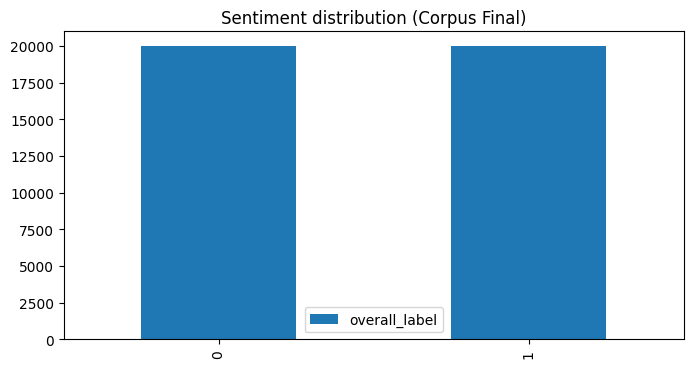

In [15]:
# Al haber obviado la puntuación intermedia de sentimiento (3), la distriibucón binomial queda 50/50
aux_df = pd.DataFrame(df['overall_label'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Sentiment distribution (Corpus Final)', figsize=(8, 4))

## N-GRAMAS

In [17]:
# Se generan bigramas y tirgramas a partir de la secuencia de palabras
bigrams_ = list(ngrams(words_review, 2))
trigrams_ = list(ngrams(words_review, 3))

# Se calcula la frecuencia de las n-gramas generados
bigrams_freq_ = FreqDist(bigrams_)
trigrams_freq_ = FreqDist(trigrams_)

In [18]:
print(f"Algunos bigramas: \n {bigrams_[:10]} \n")
print(f"Algunos bigramas: \n {trigrams_[:10]} \n")

print(f"Bigramas más frecuentes: \n {bigrams_freq_.most_common(10)} \n")
print(f"Bigramas más frecuentes: \n {trigrams_freq_.most_common(10)}")

# Como se esperaba, es necesario la eliminación de stopwords

Algunos bigramas: 
 [('deepak', 'chopra'), ('chopra', 'would'), ('would', 'like'), ('like', 'to'), ('to', 'introduce'), ('introduce', 'you'), ('you', 'to'), ('to', 'jesus.'), ('jesus.', 'not'), ('not', 'the')] 

Algunos bigramas: 
 [('deepak', 'chopra', 'would'), ('chopra', 'would', 'like'), ('would', 'like', 'to'), ('like', 'to', 'introduce'), ('to', 'introduce', 'you'), ('introduce', 'you', 'to'), ('you', 'to', 'jesus.'), ('to', 'jesus.', 'not'), ('jesus.', 'not', 'the'), ('not', 'the', 'jesus')] 

Bigramas más frecuentes: 
 [(('of', 'the'), 17310), (('this', 'book'), 11214), (('in', 'the'), 10654), (('is', 'a'), 7328), (('it', 'was'), 7254), (('to', 'the'), 6486), (('the', 'book'), 6311), (('it', 'is'), 5874), (('and', 'the'), 5795), (('to', 'be'), 5689)] 

Bigramas más frecuentes: 
 [(('this', 'book', 'is'), 1973), (('this', 'is', 'a'), 1781), (('a', 'lot', 'of'), 1525), (('this', 'book', 'was'), 1355), (('it', 'was', 'a'), 1257), (('one', 'of', 'the'), 1241), (('of', 'the', 'book'

In [19]:
# Se obtiene las listas de bigramas y trigramas más comunes junto con sus frecuencias y luego se ordena en función de las frecuencias
bg_freq_most_common = bigrams_freq_.most_common(10)
bgs_ = [str(bg[0]) for bg in bg_freq_most_common]
bgs_f_ = [bg[1] for bg in bg_freq_most_common]

tg_freq_most_common = trigrams_freq_.most_common(10)
tgs_ = [str(tg[0]) for tg in tg_freq_most_common]
tgs_f_ = [tg[1] for tg in tg_freq_most_common]

bgs_f_, bgs_ = zip(*sorted(zip(bgs_f_, bgs_)))
tgs_f_, tgs_ = zip(*sorted(zip(tgs_f_, tgs_)))

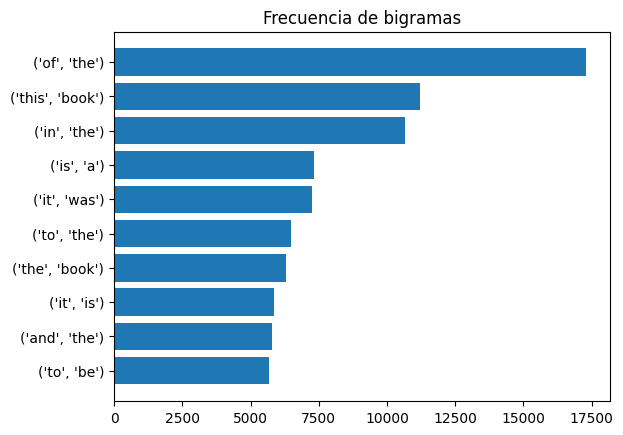

In [20]:
plt.barh(bgs_, bgs_f_)
plt.title('Frecuencia de bigramas')
plt.show()

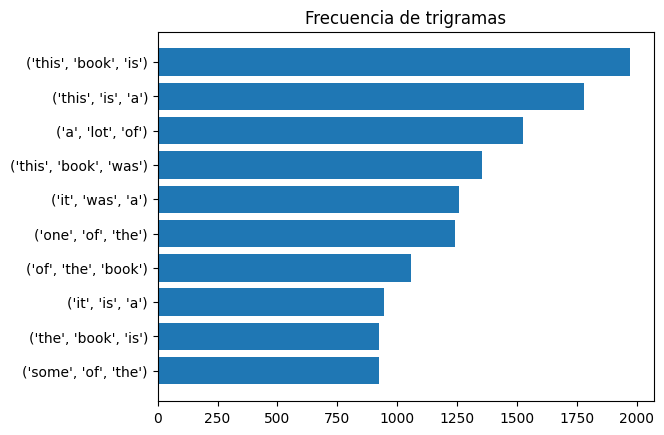

In [21]:
plt.barh(tgs_, tgs_f_)
plt.title('Frecuencia de trigramas')
plt.show()

## NUBES DE PALABRAS

In [23]:
def plot_word_cloud(text):
    """
    Crea y muestra una nube de palabras a partir de una lista de textos.

    Parámetros:
    text_list (list): Una lista de cadenas de texto.

    Esta función utiliza la librería WordCloud para generar una representación gráfica
    de las palabras más frecuentes en los textos proporcionados. La nube de palabras
    resultante se muestra en una figura utilizando Matplotlib.

    Nota: Asegúrarse de haber importado las librerías necesarias (WordCloud y Matplotlib)
    antes de usar esta función.
    """

    wordcloud = WordCloud(max_font_size=50, max_words=10, background_color="white").generate(' '.join(text))
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [24]:
# Se procesan las palabras para poder ser digeridas por la función
words_list = df['reviewText'].str.lower().str.strip().str.split()
words_list = [' '.join([word for word in words if isinstance(word, str)]) for words in words_list if isinstance(words, list)]


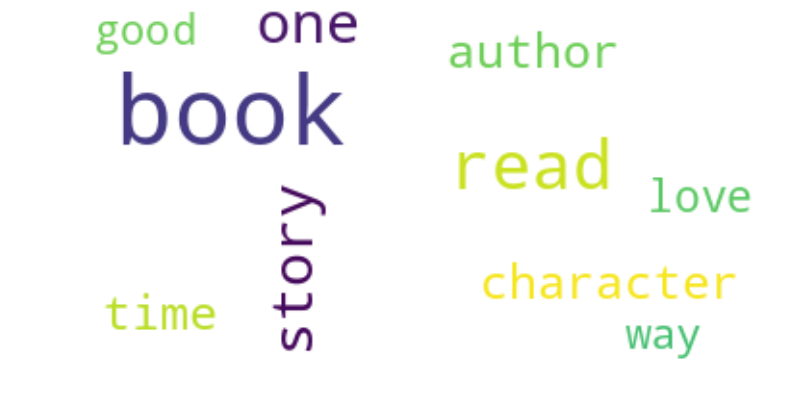

In [25]:
plot_word_cloud(words_list)

## DISPERSIÓN LÉXICA

In [27]:
target_words = [
    'time',
    'read',
    'author',
    'book',
    'story'
]

In [28]:
# Se pasan las listas de reviews a lista de palabras
words_lex = [word.lower() for text in words_list for word in text.split()]

In [29]:
# Seleccionar un subconjunto de palabras cada cierto intervalo
interval = 50
selected_words = words_lex[::interval]

<Figure size 2400x1800 with 0 Axes>

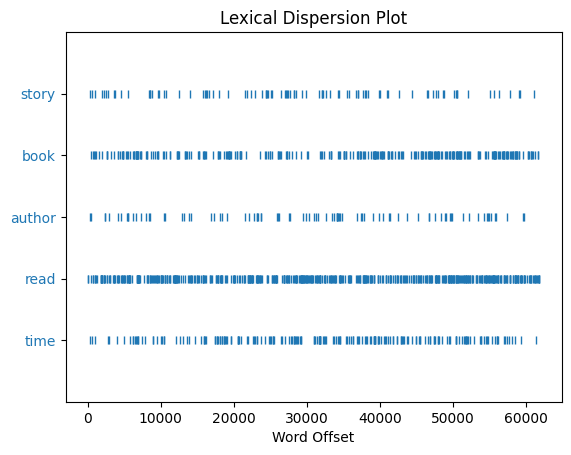

In [30]:
# Se muestra el diagrama de dispersión léxica
plt.figure(figsize=(24, 18))
plt.style.use('default')
dispersion_plot(selected_words, target_words, ignore_case=True)
plt.show()

## LEY DE ZIPF

In [32]:
# Se ordenanan las palabras por frequencia descendente
fd = FreqDist(words_lex)
fd = {k: v for k, v in sorted(fd.items(), key=lambda item: item[1], reverse=True)}

In [33]:
# Se están creando dos listas: una para almacenar los rangos de las palabras y otra para almacenar sus frecuencias correspondientes

ranks_zipf = list()
freqs_zipf = list()

for rank, word in enumerate(fd):
    ranks_zipf.append(rank+1)
    freqs_zipf.append(fd[word])

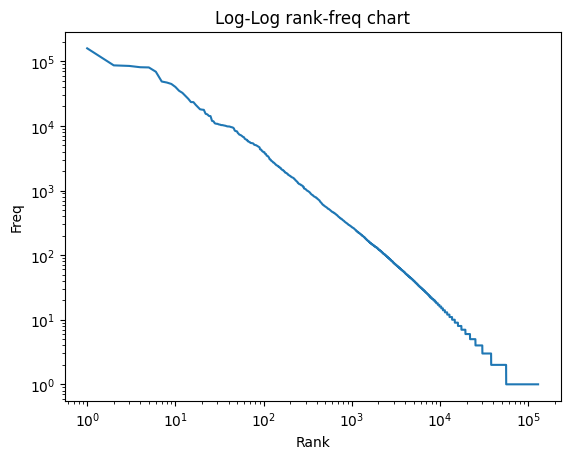

In [34]:
plt.loglog(ranks_zipf, freqs_zipf)
plt.xlabel('Rank')
plt.ylabel('Freq')
plt.title('Log-Log rank-freq chart')
plt.show()

# La gáfica miestra que el texto cumple la Ley de Zipf, según la cual establece que la frecuencia de una palabra es inversamente
# proporcional a su posición en el rango de frecuencias. En otras palabras, la palabra más común ocurre aproximadamente el doble de
# veces que la segunda palabra más común, tres veces más que la tercera palabra más común, y así sucesivamente

In [35]:
## WORD EMBEDDING

In [36]:
# Contamos el número de cores en el ordenador
cores = multiprocessing.cpu_count()
print (cores)

2


In [37]:
# Se eligen los hiperparámetros del modelo
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     #size=300,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)

In [38]:
# Se contruye el vocabulario del modelo
t = time()
sent = [row.split() for row in words_review]
w2v_model.build_vocab(sent, progress_per=10000)
print('Tiempo para construir el vocabulario: {} mins'.format(round((time() - t) / 60, 2)))

Tiempo para construir el vocabulario: 0.14 mins


In [39]:
print('Vocabulario compuesto por {} palabras'.format(len(w2v_model.wv.key_to_index)))

Vocabulario compuesto por 8695 palabras


In [40]:
t = time()

w2v_model.train(words_review, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

w2v_model.save('./w2v_model.pkl')

Time to train the model: 19.87 mins


In [52]:
print(len(words_review))
w2v_model.wv.index_to_key[:10]

3094737


['the', 'and', 'to', 'i', 'a', 'of', 'is', 'this', 'it', 'in']

In [43]:
w2v_sg = Word2Vec.load('./w2v_model.pkl')

In [44]:
w2v_sg.wv.most_similar('book')

[('returned', 0.34307512640953064),
 ('aging', 0.3266589045524597),
 ("characters'", 0.32518139481544495),
 ('amazon,', 0.31960946321487427),
 ('members', 0.3168606460094452),
 ('point', 0.3125916123390198),
 ('williams', 0.30884212255477905),
 ('prayer', 0.30404096841812134),
 ('wright', 0.29941704869270325),
 ('title', 0.29814642667770386)]

In [45]:
# Se están creando clusters de palabras similares utilizando un modelo de Word2Vec entrenado previamente (w2v_sg)
keys = ['book','read','story', 'character', 'author']

embedding_clusters = []
word_clusters = []
for word_ in keys:
    embeddings = []
    words_ = []
    for similar_word, _ in w2v_sg.wv.most_similar(word_, topn=10):
        words_.append(similar_word)
        embeddings.append(w2v_sg.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words_)

In [46]:
print(word_clusters)

[['returned', 'aging', "characters'", 'amazon,', 'members', 'point', 'williams', 'prayer', 'wright', 'title'], ['halt', 'effects', 'finding', 'appear', 'screw', 'such.', 'carrying', 'problems', 'connection', 'denver'], ['milk', 'personality', 'lordship', 'financially', 'reported', 'intriguing,', 'finish.', 'repeated', 'oblivious', 're-read'], ['download,', 'esta', 'imagined', 'honesty', 'transport', 'received', 'imaginary', 'school', 'time?', 'nice'], ['mechanical', 'surrounded', 'chopra', 'empty', 'illustration', 'wind', 'clue', 'barry', 'naughty', 'charts']]


In [47]:
# Se reduce la dimensionalidad en 2D para poder representarlas
tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

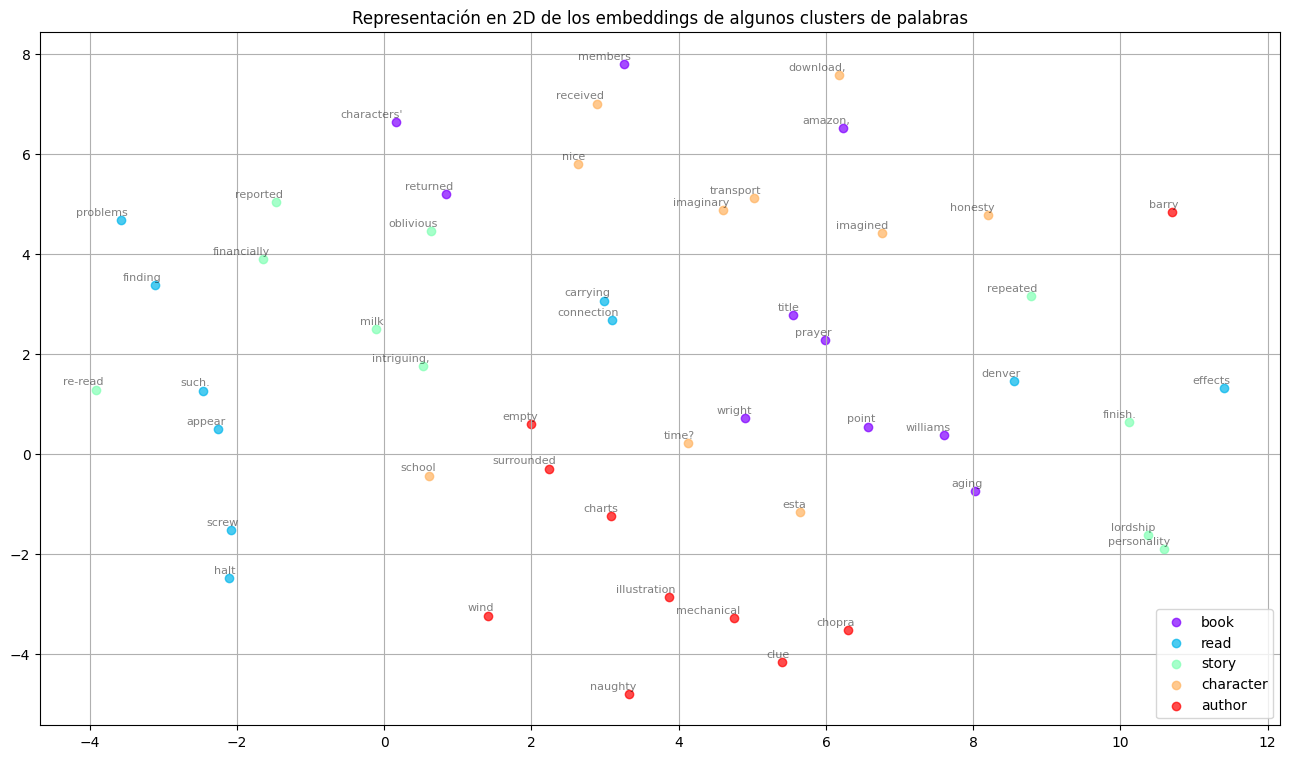

In [48]:
def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    """
    Crea un gráfico de dispersión bidimensional utilizando la técnica t-SNE para visualizar las palabras similares
    en grupos de palabras específicos.

    Parámetros:
        labels (list): Lista de etiquetas de los grupos de palabras.
        embedding_clusters (list): Lista de matrices de embeddings 2D para cada grupo de palabras.
        word_clusters (list): Lista de listas de palabras correspondientes a cada grupo.
        a (float, opcional): Opacidad de los puntos en el gráfico. Valor por defecto es 0.7.
    """

    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('Representación en 2D de los embeddings de algunos clusters de palabras')
    # plt.savefig("f/г.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words(keys, embeddings_2d, word_clusters)

In [49]:
# Guardar el DataFrame recategorizado en un archivo CSV
df.to_csv('binomial_data.csv', index=False)

In [50]:
# Comprobar que se ha guardado correctamente
df = pd.read_csv('binomial_data.csv')

print(len(df))
print("-----------")
df.head()

40000
-----------


,overall,reviewText,overall_label
0,1.0,Deepak Chopra would like to introduce you to J...,1
1,1.0,this games sucks. spend your time on somthing ...,1
2,1.0,Don't waste your money. Nothing here you can't...,1
3,1.0,How I wish Amazon would make their own content...,1
4,1.0,"Moderately interesting plot, but extremely poo...",1
